In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam as adam
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import glob
import numpy as np
from pathlib import Path
from itertools import product as myzip

In [2]:
my_path = 'D:\keras_png_slices_data\keras_png_slices_'
datasets = ['train', 'validate', 'test']
pixels = [0, 85, 170, 255]
data_dict = {}

In [77]:
def format_fn(path):
    img = tf.io.read_file(path)
    
    return tf.image.decode_png(img)

def path_2_tens(x_path, y_path):
    x = format_fn(x_path)
#     x = tf.expand_dims(x, -1)
    x = tf.cast(x, tf.float32)/127.5 - 1.0
    
    y = format_fn(y_path)
    y = tf.reshape(y, [256, 256])
    y = tf.stack([y==pixel for pixel in pixels], axis=2)
#     y = tf.expand_dims(y, -1)
    y = tf.cast(y, tf.float32)
    
    return x, y

In [47]:
def format_fn(path):
    img = tf.io.read_file(path)
    tens = tf.image.decode_png(img)
    
    return tf.reshape(tens, [256, 256, 1])

def path_2_tens(x_path, y_path):
    x = format_fn(x_path)
    x = tf.cast(x, tf.float32)/127.5 - 1.0
    
    y = format_fn(y_path)
    y = tf.reshape(y, [256, 256])
    y = tf.stack([y==pixel for pixel in pixels], axis=2)
    y = tf.cast(y, tf.float32)
    
    return x, y

In [78]:
for dataset in datasets:
    x_paths = glob.glob(my_path + dataset + '\*.png')
    y_paths = glob.glob(my_path + 'seg_' + dataset + '\*.png')
    data_dict[dataset] = tf.data.Dataset.from_tensor_slices((x_paths, y_paths))
    data_dict[dataset] = data_dict[dataset].map(path_2_tens)

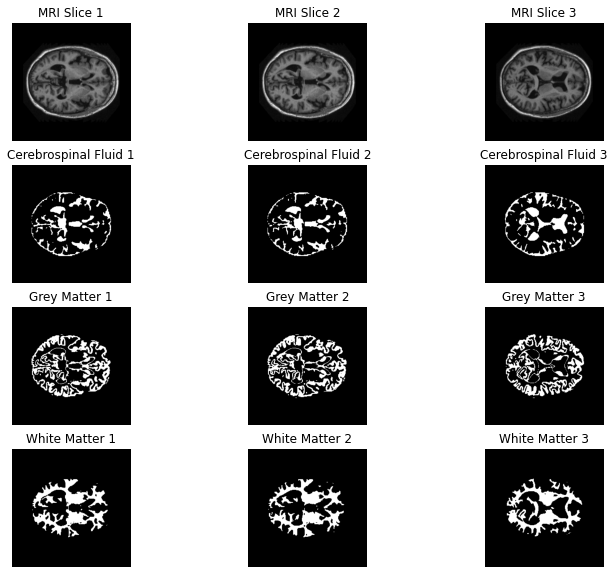

In [79]:
x_sample, y_sample = next(iter(data_dict['train'].batch(3)))
x_sample = tf.reshape(x_sample, [3, 256, 256])
y_sample = tf.reshape(y_sample, [3, 256, 256, 4])

fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(12, 10))
labels = ['Cerebrospinal Fluid ', 'Grey Matter ', 'White Matter ']

for i, j in myzip(range(3), range(1, 4)):
    ax[0][i].imshow(x_sample[i], cmap='gray')
    ax[0][i].axis('off')
    ax[0][i].set_title('MRI Slice ' + str(i+1))
    
    ax[j][i].imshow(y_sample[i, :, :, j], cmap='gray')
    ax[j][i].axis('off')
    ax[j][i].set_title(labels[j-1] + str(i+1))
    
plt.show()

In [8]:
class Downshift(tf.keras.layers.Layer):
    def __init__(self, filters, f_size=3):
        super(Downshift, self).__init__()
        self.conv2d_1 = tf.keras.layers.Conv2D(filters, f_size, activation='relu', padding='same')
        self.conv2d_2 = tf.keras.layers.Conv2D(filters, f_size, activation='relu', padding='same')
        self.maxpool_1 = tf.keras.layers.MaxPooling2D(padding='same')
        
    def call(self, x):
        x = self.conv2d_1(x)
        x = self.conv2d_2(x)
        x = self.maxpool_1(x)
        
        return x
    
class Upshift(tf.keras.layers.Layer):
    def __init__(self, concatenation, filters, f_size=3):
        super(Upshift, self).__init__()
        self.upsampling_1 = tf.keras.layers.UpSampling2D()
        self.conv2d_1 = tf.keras.layers.Conv2D(filters, f_size, activation='relu', padding='same')
        self.concatenate_1 = tf.keras.layers.Concatenate()([concatenation, self.conv2d_1])
        self.conv2d_2 = tf.keras.layers.Conv2D(filters, f_size, activation='relu', padding='same')
        self.conv2d_3 = tf.keras.layers.Conv2D(filters, f_size, activation='relu', padding='same')
        
    def call(self, x):
        x = self.upsampling_1(x)
        x = self.conv2d_1(x)
        x = self.concatenate_1(x)
        x = self.conv2d_2(x)
        x = self.conv2d_3(x)
        
        return x

In [39]:
class My_Model(tf.keras.Model):
    def __init__(self):
        super(My_Model, self).__init__()
        self.input = tf.keras.layers.InputLayer()
        self.block_1 = Downshift()

In [80]:
model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(256, 256, 1)),
    keras.layers.Conv2D(4, 3, activation='relu')
    ])

my_opt = adam(lr=10**-4)

model.compile(optimizer=my_opt, 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 254, 254, 4)       40        
Total params: 40
Trainable params: 40
Non-trainable params: 0
_________________________________________________________________


In [81]:
history = model.fit(data_dict['train'].batch(30), epochs=10,
                    validation_data=data_dict['validate'], verbose=1)

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(history.history['accuracy'], 'k', label='accuracy')
ax.plot(history.history['val_accuracy'], 'r--', label = 'val_accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend

plt.show()

ValueError: in converted code:

    C:\Users\s4353631\.conda\envs\myenv\lib\site-packages\tensorflow_core\python\keras\engine\training_v2.py:677 map_fn
        batch_size=None)
    C:\Users\s4353631\.conda\envs\myenv\lib\site-packages\tensorflow_core\python\keras\engine\training.py:2410 _standardize_tensors
        exception_prefix='input')
    C:\Users\s4353631\.conda\envs\myenv\lib\site-packages\tensorflow_core\python\keras\engine\training_utils.py:573 standardize_input_data
        'with shape ' + str(data_shape))

    ValueError: Error when checking input: expected input_11 to have 4 dimensions, but got array with shape (None, None, None)


In [26]:
my_tens = tf.constant([1, 2, 3, 4])
your_tens = my_tens[:, np.newaxis]
your_tens.shape

TensorShape([4, 1])